In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc,os,sys
import re

from sklearn import metrics, preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA, KernelPCA
from sklearn.cluster import KMeans
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

sns.set_style('darkgrid')

pd.options.display.float_format = '{:,.3f}'.format

In [54]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 500)

In [5]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        #else:
            #df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB --> {:.2f} MB (Decreased by {:.1f}%)'.format(
        start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [7]:
train_id = pd.read_csv('_input/train_identity.csv')
train_trn = pd.read_csv('_input/train_transaction.csv')
test_id = pd.read_csv('_input/test_identity.csv')
test_trn = pd.read_csv('_input/test_transaction.csv')

In [8]:
train_id = reduce_mem_usage(train_id)
train_trn = reduce_mem_usage(train_trn)
test_id = reduce_mem_usage(test_id)
test_trn = reduce_mem_usage(test_trn)

Memory usage of dataframe is 45.00 MB --> 25.00 MB (Decreased by 44.0%)
Memory usage of dataframe is 1775.00 MB --> 542.00 MB (Decreased by 69.0%)
Memory usage of dataframe is 44.00 MB --> 25.00 MB (Decreased by 43.0%)
Memory usage of dataframe is 1519.00 MB --> 472.00 MB (Decreased by 68.0%)


In [17]:
ccols = ['C%d' % i for i in range(1,15)]
dcols = ['D%d' % i for i in range(1,16)]
mcols = ['M%d' % i for i in range(1,10)]
vcols = ['V%d' % i for i in range(1,340)]

In [34]:
train_trn_f0 = train_trn[train_trn['isFraud'] == 0]
train_trn_f1 = train_trn[train_trn['isFraud'] == 1]
print(train_trn_f0.shape, train_trn_f1.shape)

def plotTrnHistByFraud(col, bins=20, figsize=(8,3)):
    with np.errstate(invalid='ignore'):
        plt.figure(figsize=figsize)
        plt.hist([train_trn_f0[col], train_trn_f1[col]], bins=bins, density=True, color=['royalblue', 'orange'])
        plt.show()

def plotTrnLogHistByFraud(col, bins=20, figsize=(8,3)):
    with np.errstate(invalid='ignore'):
        plt.figure(figsize=figsize)
        plt.hist([np.log1p(train_trn_f0[col]), np.log1p(train_trn_f1[col])], bins=bins, density=True, color=['royalblue', 'orange'])
        plt.show()
        
def plotTrnCategoryRateBar(col, topN=np.nan, figsize=(8,3)):
    a, b = train_trn_f0, train_trn_f1
    if topN == topN: # isNotNan
        vals = b[col].value_counts(normalize=True).to_frame().iloc[:topN,0]
        subA = a.loc[a[col].isin(vals.index.values), col]
        df = pd.DataFrame({'normal':subA.value_counts(normalize=True), 'fraud':vals})
    else:
        df = pd.DataFrame({'normal':a[col].value_counts(normalize=True), 'fraud':b[col].value_counts(normalize=True)})
    df.sort_values('fraud', ascending=False).plot.bar(figsize=figsize)
    plt.show()

((569877, 394), (20663, 394))


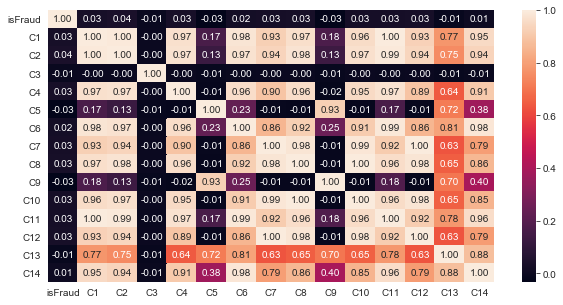

In [21]:
plt.figure(figsize=(10, 5))

corr = train_trn[['isFraud'] + ccols].corr()
sns.heatmap(corr, annot=True, fmt='.2f')

plt.show()

In [24]:
train_trn['card1'].value_counts().head(10)

7919     14932
9500     14162
15885    10361
17188    10344
15066     7945
12695     7091
12544     6773
6019      6771
2803      6141
7585      5334
Name: card1, dtype: int64

D1 : 642 values in train, 643 values in test, 641 values in both 99.99980% repeated. 


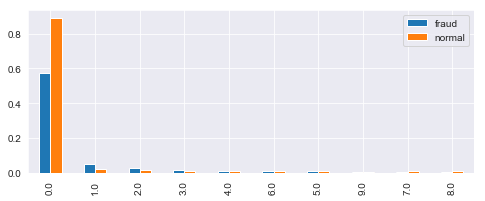

D2 : 642 values in train, 643 values in test, 641 values in both 99.99980% repeated. 


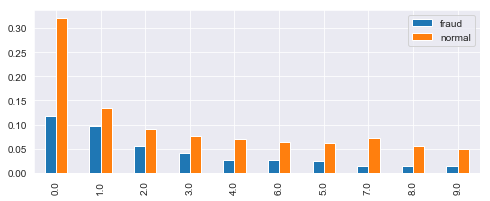

D3 : 650 values in train, 888 values in test, 648 values in both 99.79554% repeated. 


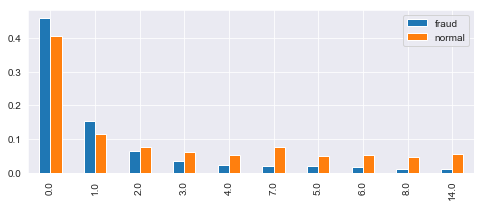

D4 : 809 values in train, 1057 values in test, 795 values in both 97.77044% repeated. 


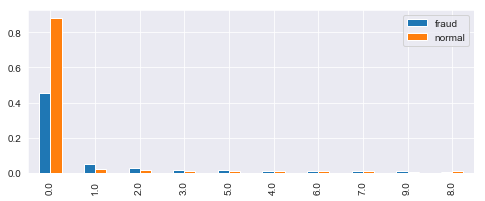

D5 : 689 values in train, 962 values in test, 688 values in both 99.66982% repeated. 


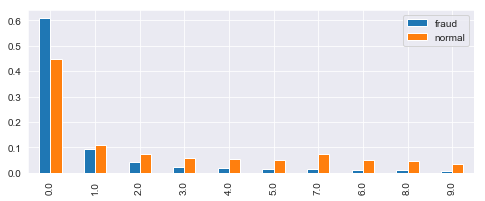

D6 : 830 values in train, 1073 values in test, 825 values in both 99.75942% repeated. 


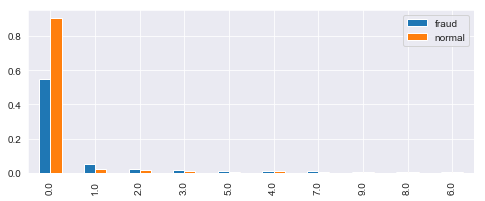

D7 : 598 values in train, 905 values in test, 596 values in both 99.76435% repeated. 


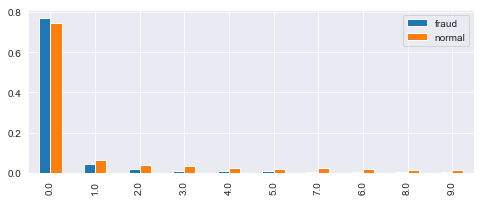

D8 : 5368 values in train, 5523 values in test, 5061 values in both 99.63429% repeated. 


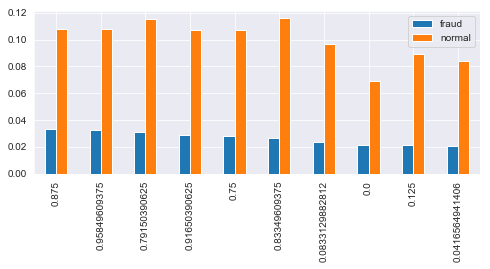

D9 : 25 values in train, 25 values in test, 24 values in both 100.00000% repeated. 


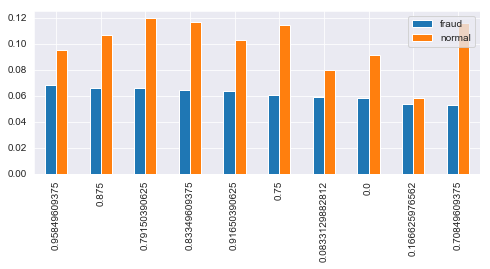

D10 : 819 values in train, 1076 values in test, 818 values in both 98.18450% repeated. 


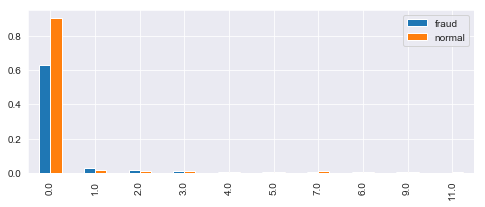

D11 : 677 values in train, 881 values in test, 669 values in both 94.44395% repeated. 


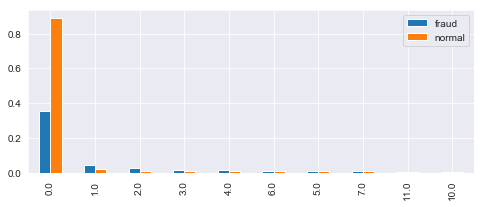

D12 : 636 values in train, 867 values in test, 633 values in both 99.55811% repeated. 


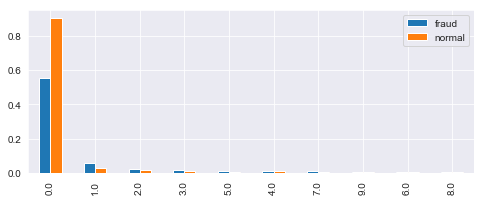

D13 : 578 values in train, 806 values in test, 555 values in both 99.87606% repeated. 


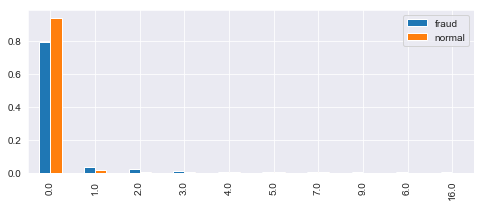

D14 : 803 values in train, 1032 values in test, 797 values in both 99.79988% repeated. 


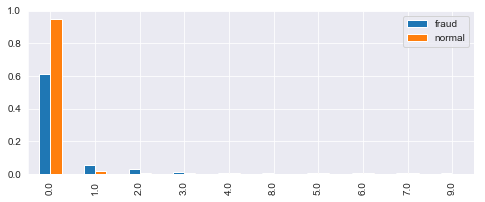

D15 : 860 values in train, 1079 values in test, 846 values in both 98.65520% repeated. 


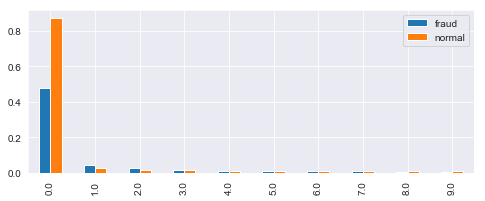

In [42]:
for c in dcols:
    values_trn = train_trn[c].unique()
    values_tst = test_trn[c].unique()
    values_both = list(set(values_trn).intersection(values_tst))
    n_trn = len(values_trn)
    n_tst = len(values_tst)
    n_both = len(values_both)
    repeatedness = test_trn[c].isin(values_trn).mean()
    msg = '%s : %d values in train, %d values in test, %d values in both %.5f%% repeated. ' % (c, n_trn, n_tst, n_both, repeatedness*100)
    print(msg)
    plotTrnCategoryRateBar(c, 10)
    plt.show()

<Figure size 864x288 with 0 Axes>

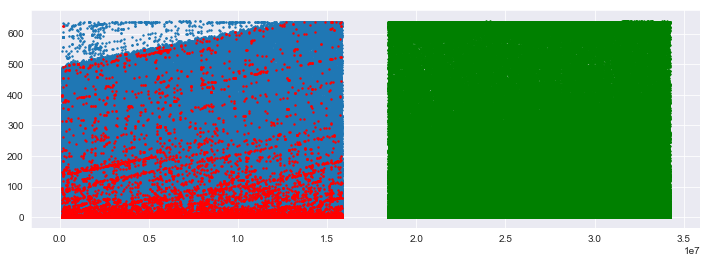

In [44]:
plt.figure(figsize=(12, 4))

plt.scatter(train_trn_f0['TransactionDT'], train_trn_f0['D1'], s=2)
plt.scatter(train_trn_f1['TransactionDT'], train_trn_f1['D1'], s=2, c='r')
plt.scatter(test_trn['TransactionDT'], test_trn['D1'], s=2, c='g')

plt.show()

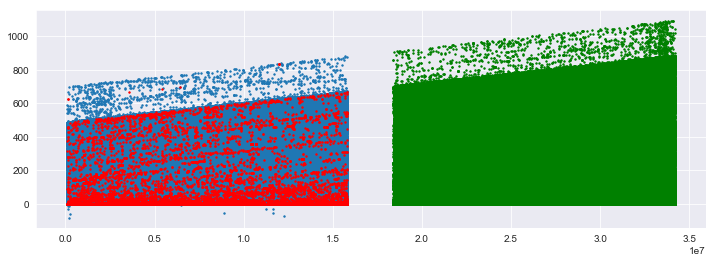

In [47]:
plt.figure(figsize=(12,4))

# ref. https://www.kaggle.com/kyakovlev/ieee-columns-scaling
plt.scatter(train_trn_f0['TransactionDT'], train_trn_f0['D15'], s=2)
plt.scatter(train_trn_f1['TransactionDT'], train_trn_f1['D15'], s=2, c='r')
plt.scatter(test_trn['TransactionDT'], test_trn['D15'], s=2, c='g')

plt.show()

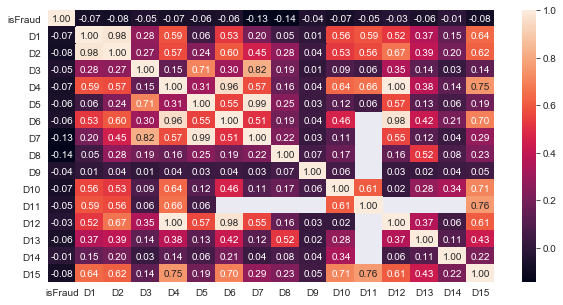

In [48]:
plt.figure(figsize=(10,5))

corr = train_trn[['isFraud'] + dcols].corr()
sns.heatmap(corr, annot=True, fmt='.2f')

plt.show()

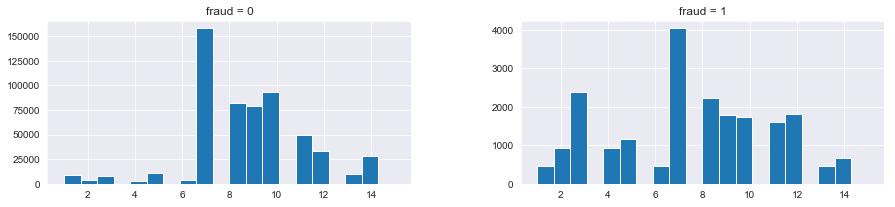

In [51]:
fig, ax = plt.subplots(1, 2, figsize=(15, 3))

train_trn_f0[dcols].isnull().sum(axis=1).to_frame().hist(ax=ax[0], bins=20)
ax[0].set_title('fraud = 0')
train_trn_f1[dcols].isnull().sum(axis=1).to_frame().hist(ax=ax[1], bins=20)
ax[1].set_title('fraud = 1')

plt.show()

In [52]:
for c in mcols:
    print(c, train_trn[c].unique())

('M1', array(['T', nan, 'F'], dtype=object))
('M2', array(['T', nan, 'F'], dtype=object))
('M3', array(['T', nan, 'F'], dtype=object))
('M4', array(['M2', 'M0', nan, 'M1'], dtype=object))
('M5', array(['F', 'T', nan], dtype=object))
('M6', array(['T', 'F', nan], dtype=object))
('M7', array([nan, 'F', 'T'], dtype=object))
('M8', array([nan, 'F', 'T'], dtype=object))
('M9', array([nan, 'F', 'T'], dtype=object))


In [61]:
import datetime

START_DATE = '2017-11-30'
startdate = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
train_trn['Date'] = train_trn['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))
train_trn['_ymd'] = train_trn['Date'].dt.year.astype(str) + '-' + train_trn['Date'].dt.month.astype(str) + '-' + train_trn['Date'].dt.day.astype(str)
train_trn['_year_month'] = train_trn['Date'].dt.year.astype(str) + '-' + train_trn['Date'].dt.month.astype(str)
train_trn['_weekday'] = train_trn['Date'].dt.dayofweek
train_trn['_hour'] = train_trn['Date'].dt.hour
train_trn['_day'] = train_trn['Date'].dt.day

In [62]:
train_trn_f0 = train_trn[train_trn['isFraud'] == 0]
train_trn_f1 = train_trn[train_trn['isFraud'] == 1]

print(train_trn_f0.shape)
print(train_trn_f1.shape)

(569877, 400)
(20663, 400)


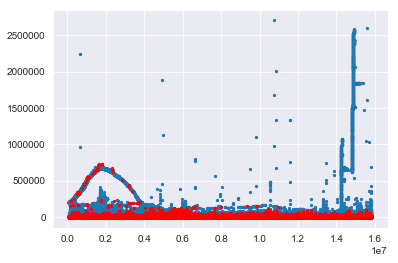

In [66]:
vsum0 = train_trn_f0[vcols].sum(axis=1)
vsum1 = train_trn_f1[vcols].sum(axis=1)

plt.scatter(train_trn_f0['TransactionDT'], vsum0, s=5)
plt.scatter(train_trn_f1['TransactionDT'], vsum1, s=5, c='r')

plt.show()

In [65]:
train_trn_f0['_ymd'].head(10)

0    2017-12-1
1    2017-12-1
2    2017-12-1
3    2017-12-1
4    2017-12-1
5    2017-12-1
6    2017-12-1
7    2017-12-1
8    2017-12-1
9    2017-12-1
Name: _ymd, dtype: object

In [68]:
n_trn_lst = []
n_tst_lst = []
n_both_lst = []
repeatedness_lst = []
for c in vcols:
    values_trn = train_trn[c].unique()
    values_tst = test_trn[c].unique()
    values_both = list(set(values_trn).intersection(values_tst))
    n_trn = len(values_trn)
    n_tst = len(values_tst)
    n_both = len(values_both)
    repeatedness = test_trn[c].isin(values_trn).mean()
#     msg = '%s : %d values in train, %d values in test, %d values in both %.5f%% repeated. ' % (c, n_trn, n_tst, n_both, repeatedness*100)
#     print(msg)
    n_trn_lst.append(n_trn)
    n_tst_lst.append(n_tst)
    n_both_lst.append(n_both)
    repeatedness_lst.append(repeatedness)
    
    
df = pd.DataFrame({'n_trn': n_trn_lst, 'n_tst': n_tst_lst, 'n_both': n_both_lst, 'repeatedness': repeatedness_lst},
                  index=vcols)

In [78]:
lst = df[df['n_trn'] > 5000].index.tolist()
for c in ['V130', 'V310', 'V312']:
    lst.remove(c)

In [79]:
lst

['V126',
 'V127',
 'V128',
 'V132',
 'V133',
 'V134',
 'V160',
 'V202',
 'V203',
 'V204',
 'V211',
 'V212',
 'V213',
 'V263',
 'V264',
 'V265',
 'V274',
 'V306',
 'V307',
 'V308',
 'V314',
 'V316',
 'V317',
 'V318',
 'V320',
 'V321']